In [216]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX

from itertools import product
from typing import Union
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

In [217]:
sales_df = pd.read_csv('drive/MyDrive/Colab Datasets/store-sales-time-series-forecasting/train.csv')
sales_df.tail(5)

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [218]:
stores_df = pd.read_csv('drive/MyDrive/Colab Datasets/store-sales-time-series-forecasting/stores.csv')
stores_df.tail(5) 

,store_nbr,city,state,type,cluster
49,50,Ambato,Tungurahua,A,14
50,51,Guayaquil,Guayas,A,17
51,52,Manta,Manabi,A,11
52,53,Manta,Manabi,D,13
53,54,El Carmen,Manabi,C,3


In [219]:
oil_df = pd.read_csv('drive/MyDrive/Colab Datasets/store-sales-time-series-forecasting/oil.csv')
oil_df.tail(5)

,date,dcoilwtico
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96
1217,2017-08-31,47.26


In [220]:
holiday_events_df = pd.read_csv('drive/MyDrive/Colab Datasets/store-sales-time-series-forecasting/holidays_events.csv')
holiday_events_df.tail(5)

,date,type,locale,locale_name,description,transferred
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False


In [221]:
# convertendo a coluna 'date' para o formato datetime
sales_df['date'] = pd.to_datetime(sales_df['date'])
oil_df['date'] = pd.to_datetime(oil_df['date'])
holiday_events_df['date'] = pd.to_datetime(holiday_events_df['date'])

# estabelecendo o índice
sales_df.set_index('date', inplace=True)
oil_df.set_index('date', inplace=True)
holiday_events_df.set_index('date', inplace=True)

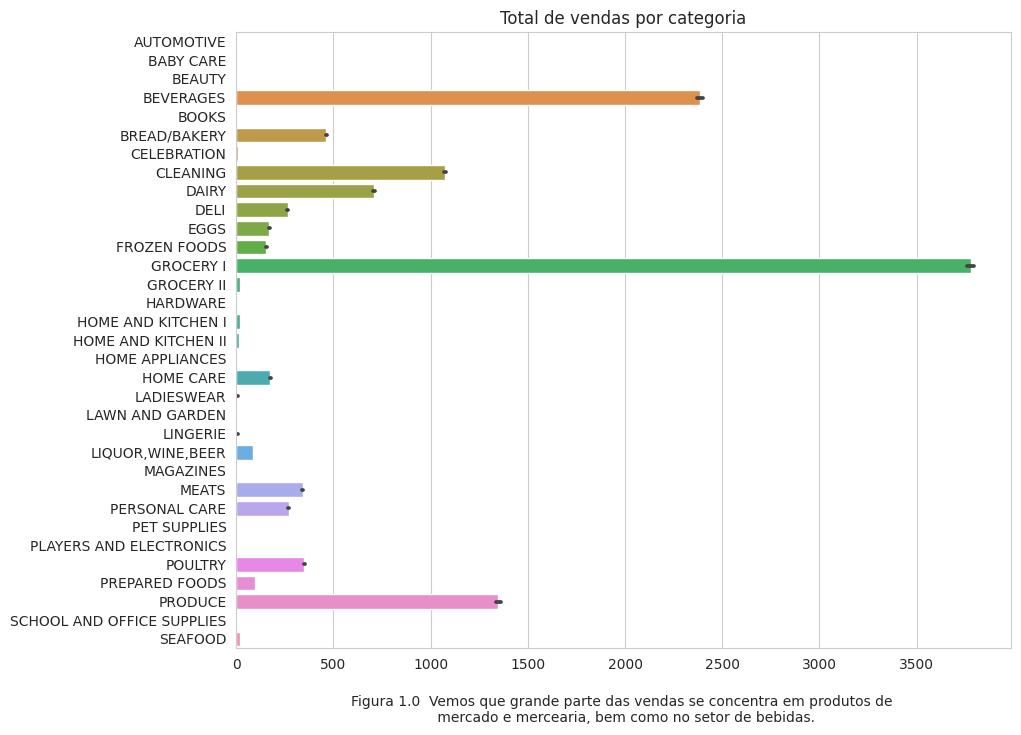

In [224]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))
sns.barplot(x="sales", y="family", data=sales_df)
plt.xlabel("")
plt.ylabel("")
plt.title("Total de vendas por categoria")
plt.annotate('Figura 1.0  Vemos que grande parte das vendas se concentra em produtos de \n mercado e mercearia, bem como no setor de bebidas.', xy=(0.5, -0.1), va='center', xycoords='axes fraction', ha='center')
plt.show()

## 1. Análise exploratória

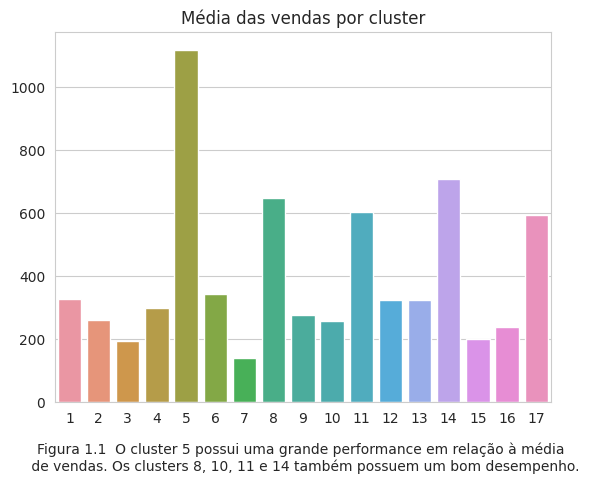

In [230]:
# Agrupa as médias de vendas por cluster
sales_by_cluster = stores_df.merge(sales_df, on='store_nbr').groupby('cluster')['sales'].mean().reset_index()
sns.barplot(x='cluster', y='sales', data=sales_by_cluster)
plt.title('Média das vendas por cluster')
plt.xlabel("")
plt.ylabel("")
plt.annotate('Figura 1.1  O cluster 5 possui uma grande performance em relação à média \n de vendas. Os clusters 8, 10, 11 e 14 também possuem um bom desempenho.', xy=(0.5, -0.15), va='center', xycoords='axes fraction', ha='center')
plt.show()

In [87]:
merged_df = pd.merge(stores_df, sales_df, on='store_nbr')

# Agrupando por cidade e cluster e calculando a média de vendas
grouped_df = merged_df.groupby(['city', 'cluster']).mean()['sales'].reset_index()

# Pivotando a tabela
pivot_df = grouped_df.pivot(index='city', columns='cluster', values='sales')

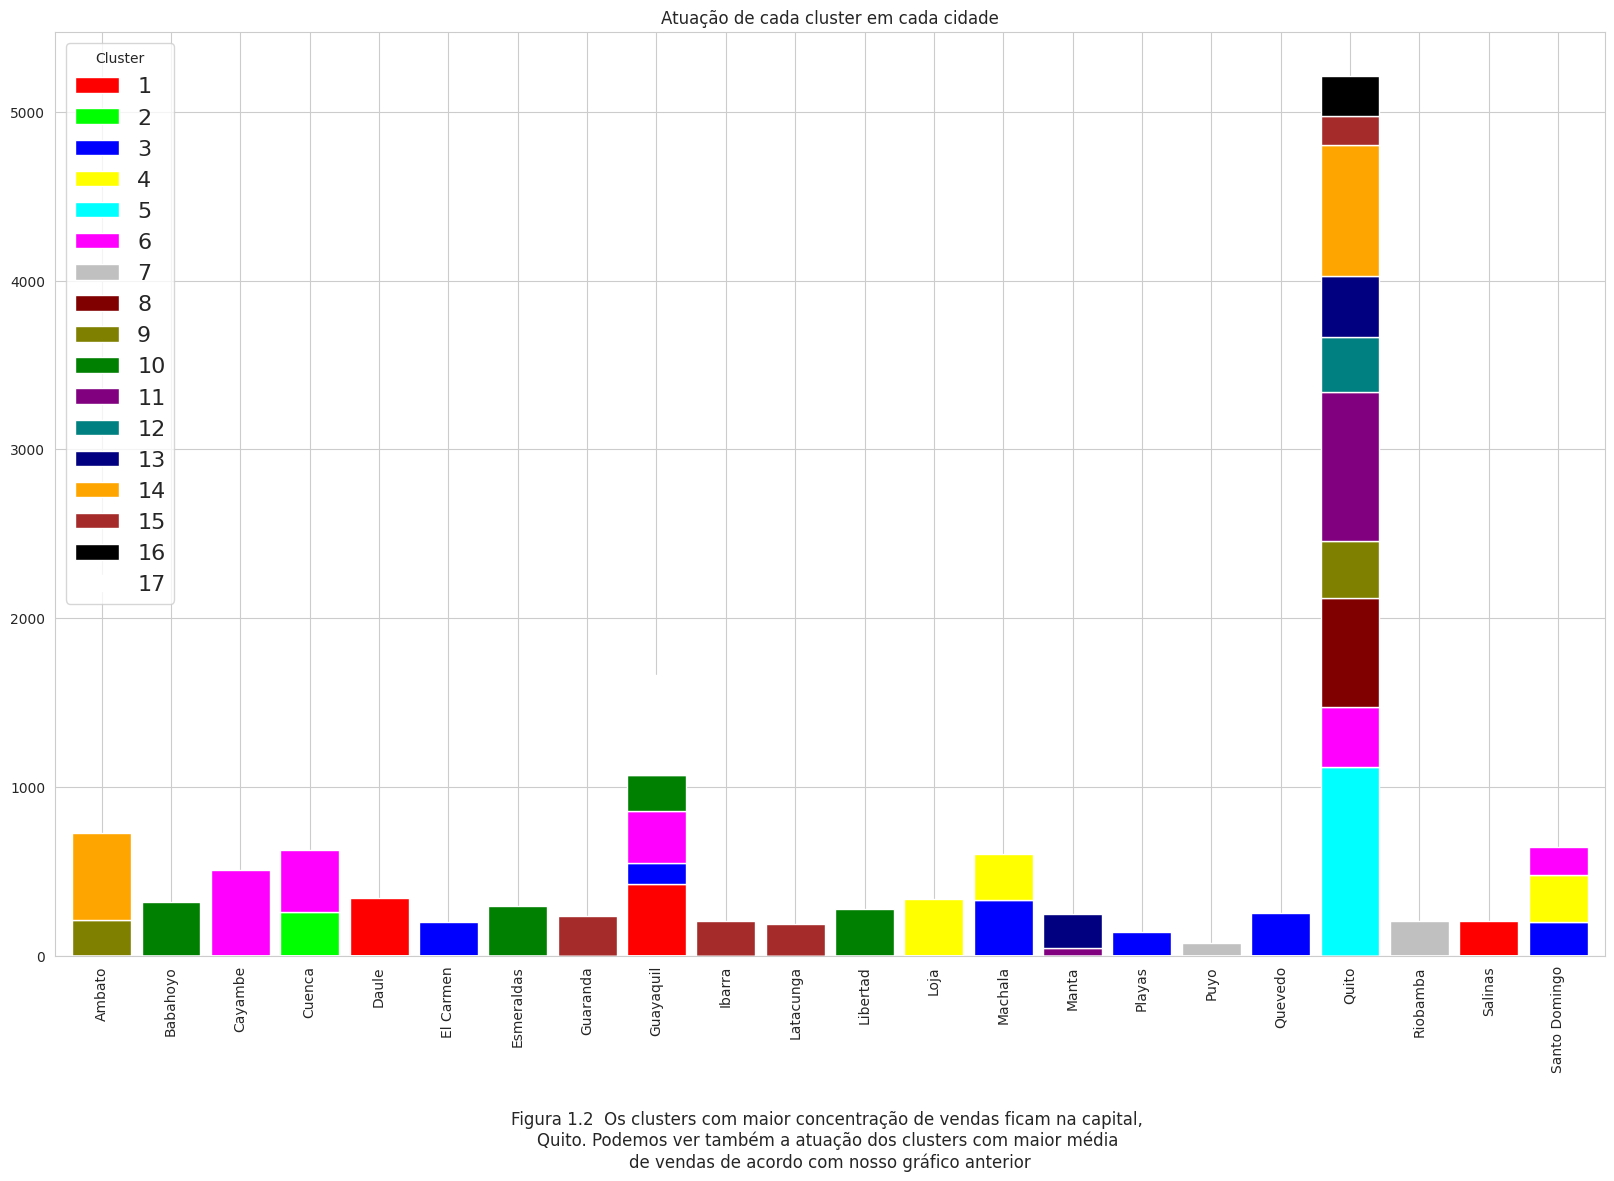

In [101]:
colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#00FFFF', '#FF00FF', '#C0C0C0', '#800000', '#808000', '#008000', '#800080', '#008080', '#000080', '#FFA500', '#A52A2A', '#000000', '#FFFFFF']
pivot_df.plot(kind='bar', stacked=True, figsize=(20,12), width=0.85, color=colors)

plt.ylabel('')
plt.xlabel('')
plt.title('Atuação de cada cluster em cada cidade')
plt.legend(title='Cluster', loc='upper left', fontsize=16)
plt.annotate('Figura 1.2  Os clusters com maior concentração de vendas ficam na capital, \nQuito. Podemos ver também a atuação dos clusters com maior média \nde vendas de acordo com nosso gráfico anterior', xy=(0.5, -0.2), va='center', fontsize=12, xycoords='axes fraction', ha='center')
plt.show()

## 2. Análise da série temporal

In [11]:
beverages = sales_df.loc[(sales_df['family'] == 'BEVERAGES') & (sales_df['sales'] != 0.00), ['sales', 'onpromotion']]
daily_sales_beverages = beverages.resample('D').sum()

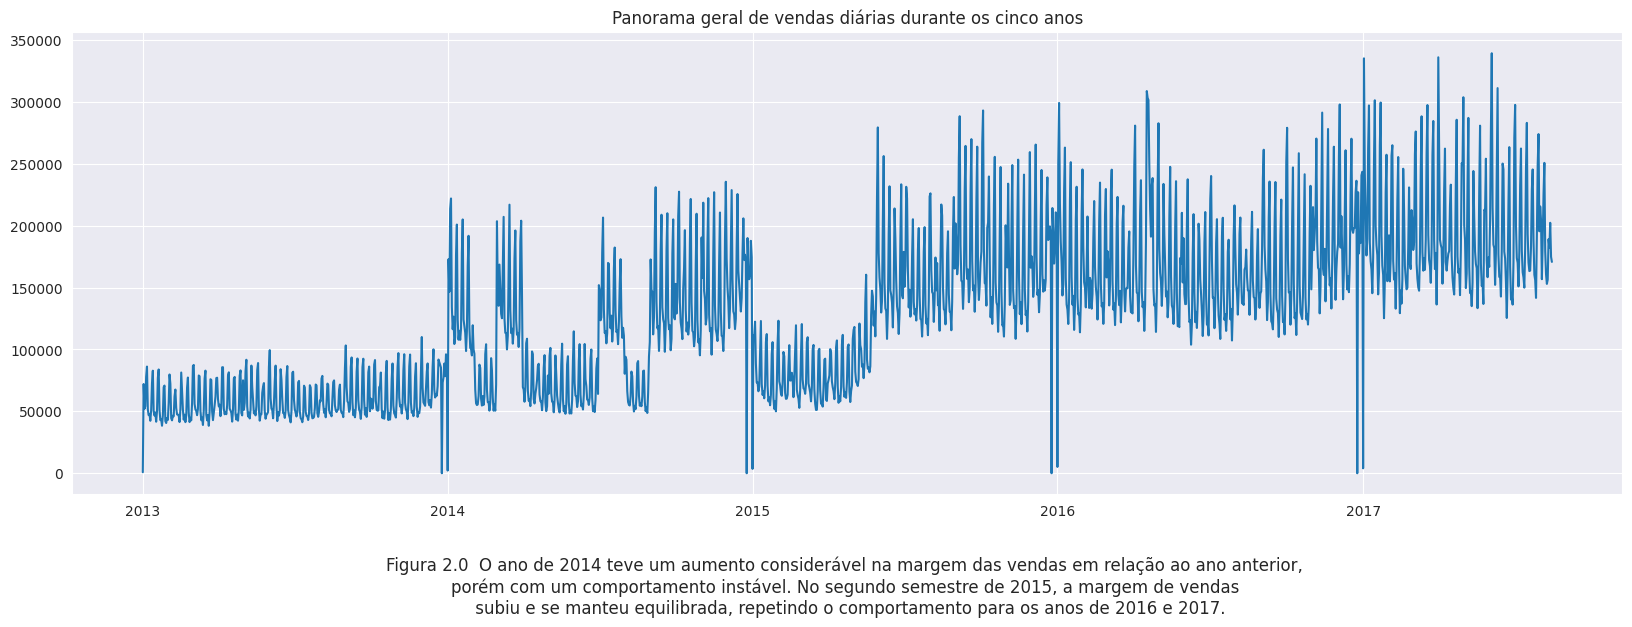

In [109]:
plt.figure(figsize=(20,6))
sns.set_style("darkgrid")
sns.lineplot(x='date', y='sales', data=daily_sales_beverages)
plt.ylabel('')
plt.xlabel('')
plt.title('Panorama geral de vendas diárias durante os cinco anos')
plt.annotate('Figura 2.0  O ano de 2014 teve um aumento considerável na margem das vendas em relação ao ano anterior, \nporém com um comportamento instável. No segundo semestre de 2015, a margem de vendas \n subiu e se manteu equilibrada, repetindo o comportamento para os anos de 2016 e 2017.', xy=(0.5, -0.2), va='center', fontsize=12, xycoords='axes fraction', ha='center')
plt.show()

In [110]:
daily_sales_beverages_2016 = daily_sales_beverages.loc[(daily_sales_beverages.index.year == 2016)]
daily_sales_beverages_2016 = daily_sales_beverages_2016.drop(daily_sales_beverages_2016.index[0])

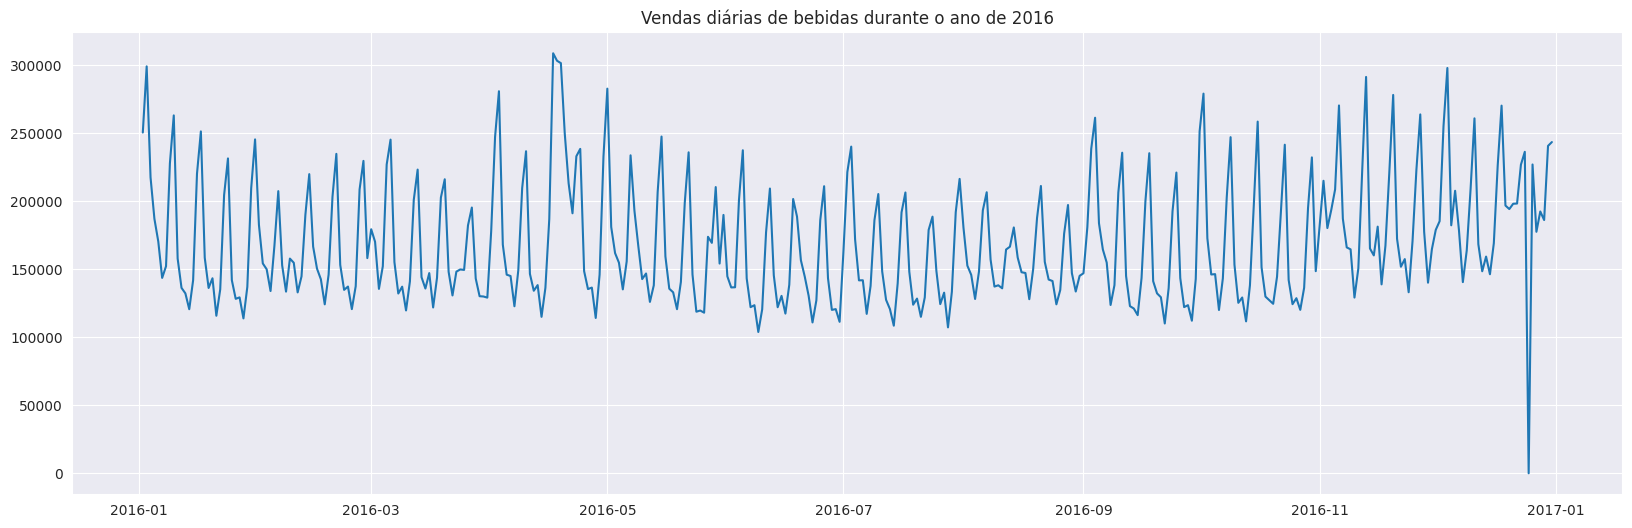

In [112]:
plt.figure(figsize=(20,6))
sns.set_style("darkgrid")
sns.lineplot(x='date', y='sales', data=daily_sales_beverages_2016)
plt.ylabel('')
plt.xlabel('')
plt.title('Vendas diárias de bebidas durante o ano de 2016')
plt.show()

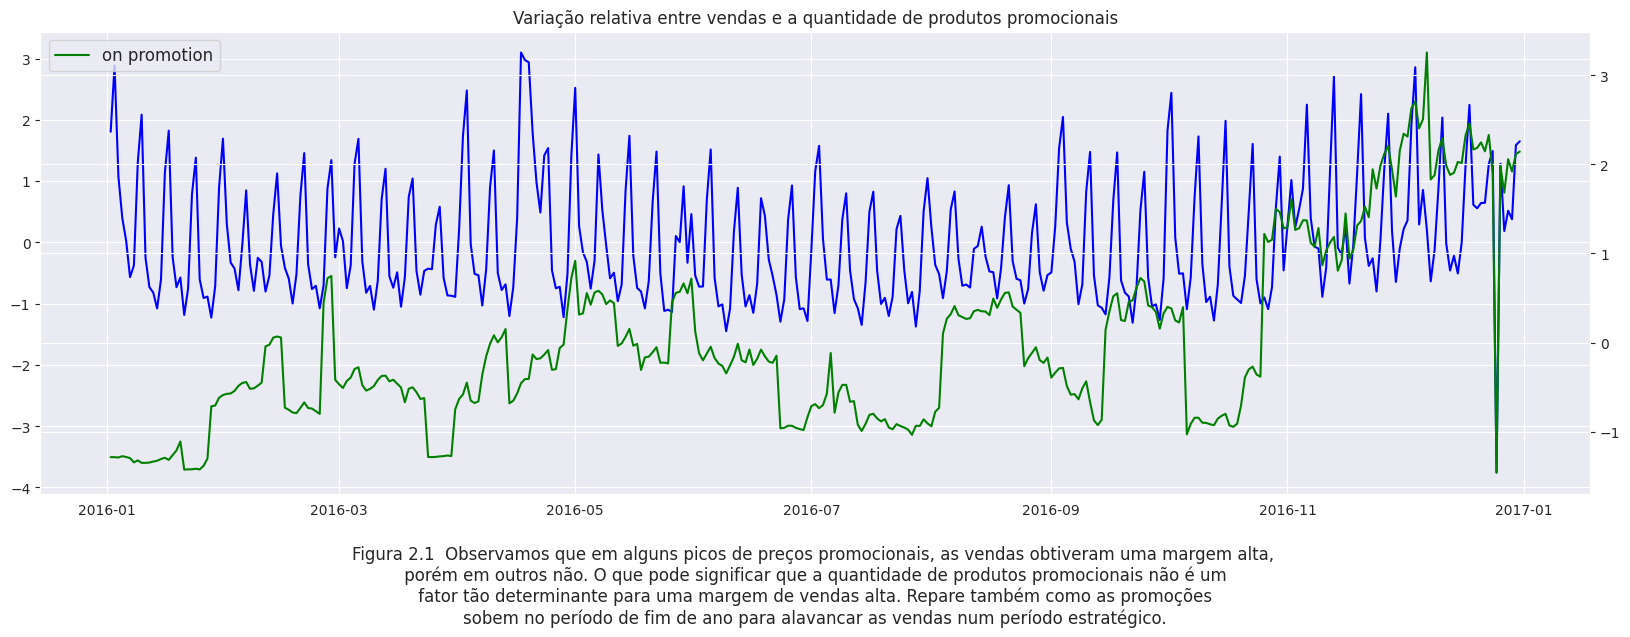

In [128]:
# Normalizando as colunas
normalized_sales = (daily_sales_beverages_2016['sales'] - daily_sales_beverages_2016['sales'].mean()) / daily_sales_beverages_2016['sales'].std()
normalized_onpromotion = (daily_sales_beverages_2016['onpromotion'] - daily_sales_beverages_2016['onpromotion'].mean()) / daily_sales_beverages_2016['onpromotion'].std()

# Plotando as colunas em diferentes subplots
fig, ax1 = plt.subplots(figsize=(20, 6))
ax2 = ax1.twinx()

ax1.plot(daily_sales_beverages_2016.index, normalized_sales, color='blue', label='sales')
ax2.plot(daily_sales_beverages_2016.index, normalized_onpromotion, color='green', label='on promotion')

plt.title('Variação relativa entre vendas e a quantidade de produtos promocionais')
plt.legend(loc='upper left', fontsize=12)
plt.annotate('Figura 2.1  Observamos que em alguns picos de preços promocionais, as vendas obtiveram uma margem alta, \n porém em outros não. O que pode significar que a quantidade de produtos promocionais não é um \n fator tão determinante para uma margem de vendas alta. Repare também como as promoções \nsobem no período de fim de ano para alavancar as vendas num período estratégico.', xy=(0.5, -0.2), va='center', fontsize=12, xycoords='axes fraction', ha='center')
plt.show()

In [129]:
dates = pd.date_range(start='2016-01-02', end='2016-12-31', freq='D')

oil_df = oil_df.reset_index()
oil_df_2016 = oil_df[(oil_df['date'] >= '2016-01-02') & (oil_df['date'] <= '2016-12-31')]
df_dates = pd.DataFrame({'date': dates})
df_oil_2016_complete = df_dates.merge(oil_df_2016, on='date', how='left') #  left join para preservar todas as datas de "df_dates":
df_oil_2016_complete['dcoilwtico'].fillna(method='ffill', inplace=True) # preencher com valor anterior
df_oil_2016_complete['dcoilwtico'].fillna(method='bfill', inplace=True) # preencher com o próximo valor 
df_oil_2016_complete.set_index('date', inplace=True)

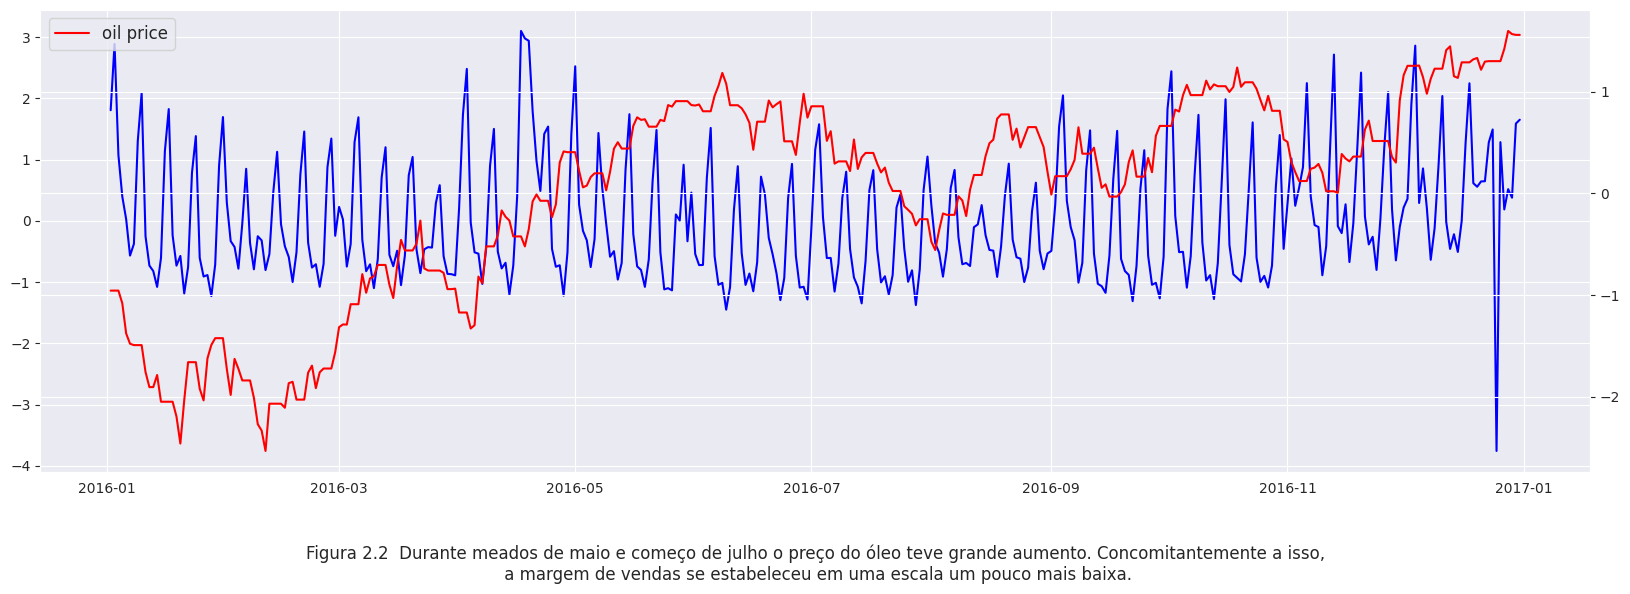

In [135]:
normalized_dcoilwtico = (df_oil_2016_complete['dcoilwtico'] - df_oil_2016_complete['dcoilwtico'].mean()) / df_oil_2016_complete['dcoilwtico'].std()

# Plotando as colunas em diferentes subplots
fig, ax1 = plt.subplots(figsize=(20, 6))
ax2 = ax1.twinx()

ax1.plot(daily_sales_beverages_2016.index, normalized_sales, color='blue', label='sales')
ax2.plot(daily_sales_beverages_2016.index, normalized_dcoilwtico, color='red', label='oil price')

plt.title('')
plt.legend(loc='upper left', fontsize=12)
plt.annotate('Figura 2.2  Durante meados de maio e começo de julho o preço do óleo teve grande aumento. Concomitantemente a isso,\n a margem de vendas se estabeleceu em uma escala um pouco mais baixa.', xy=(0.5, -0.2), va='center', fontsize=12, xycoords='axes fraction', ha='center')
plt.show()

In [136]:
holiday_events_df = holiday_events_df.reset_index()

In [137]:
#national_holidays_2016 = holiday_events_df[(holiday_events_df['date'] >= '2016-01-02') & (holiday_events_df['date'] <= '2016-12-31') & (holiday_events_df['locale'] == 'National')]
national_holidays_2016 = holiday_events_df[(holiday_events_df['date'] >= '2016-01-02') & (holiday_events_df['date'] <= '2016-12-31')]
dates = pd.date_range(start='2016-01-02', end='2016-12-31', freq='D')
df_dates_holidays = pd.DataFrame({'date': dates})

# Definir inicialmente todos os valores da coluna 'is_holiday' como False
df_dates_holidays['is_holiday'] = False

# Marcar as datas que tiveram feriado como True
df_dates_holidays.loc[df_dates_holidays['date'].isin(national_holidays_2016['date']), 'is_holiday'] = True
df_dates_holidays.set_index('date', inplace=True)
df_dates_holidays['is_holiday'] = df_dates_holidays['is_holiday'].astype(int)

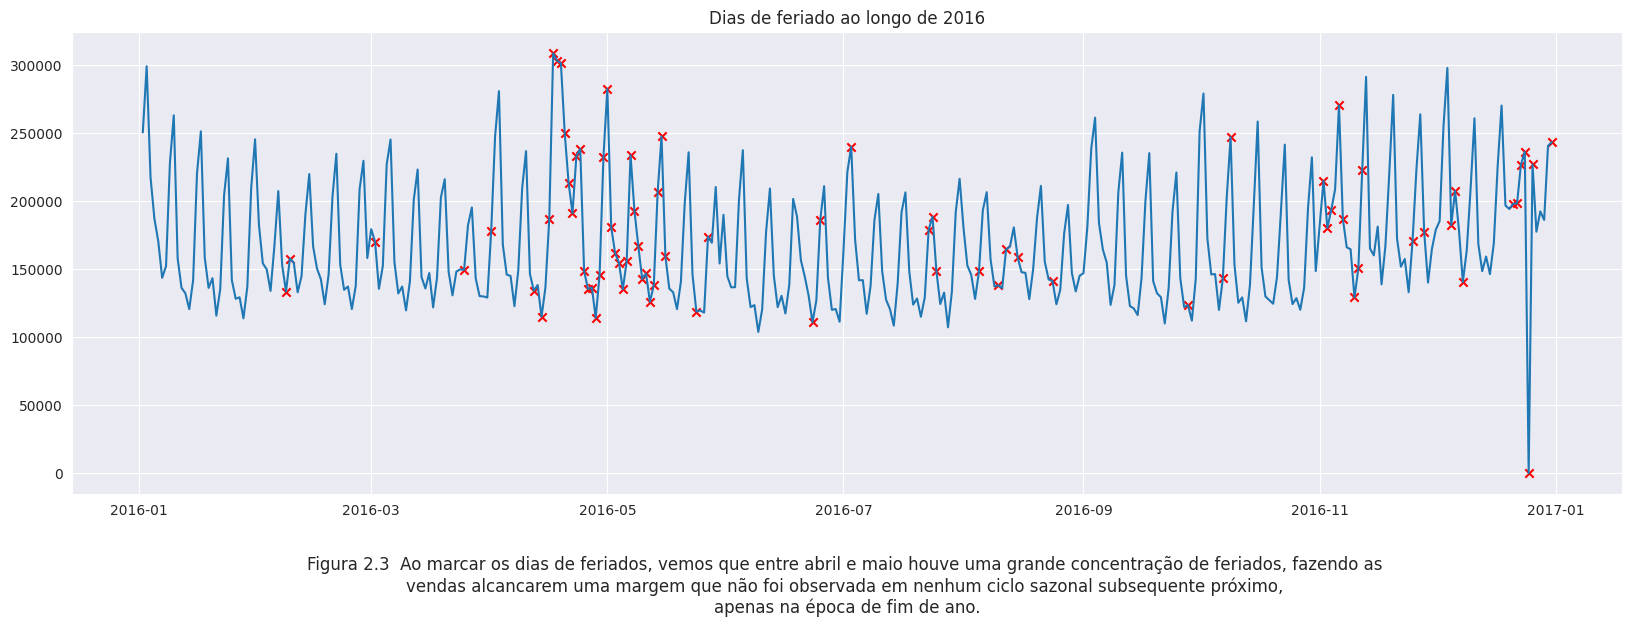

In [145]:
plt.figure(figsize=(20,6))
sns.set_style("darkgrid")
sns.lineplot(x='date', y='sales', data=daily_sales_beverages_2016)
plt.ylabel('')
plt.xlabel('')
plt.title('Dias de feriado ao longo de 2016')
plt.annotate('Figura 2.3  Ao marcar os dias de feriados, vemos que entre abril e maio houve uma grande concentração de feriados, fazendo as \nvendas alcancarem uma margem que não foi observada em nenhum ciclo sazonal subsequente próximo, \napenas na época de fim de ano.', xy=(0.5, -0.2), va='center', fontsize=12, xycoords='axes fraction', ha='center')

# Marcar os dias de feriado
for date, is_holiday in df_dates_holidays.iterrows():
    if is_holiday['is_holiday']:
        #plt.axvline(x=date, color='red', linestyle='--')
        plt.scatter(date, daily_sales_beverages_2016.loc[date, 'sales'], color='red', marker='x')

plt.show()

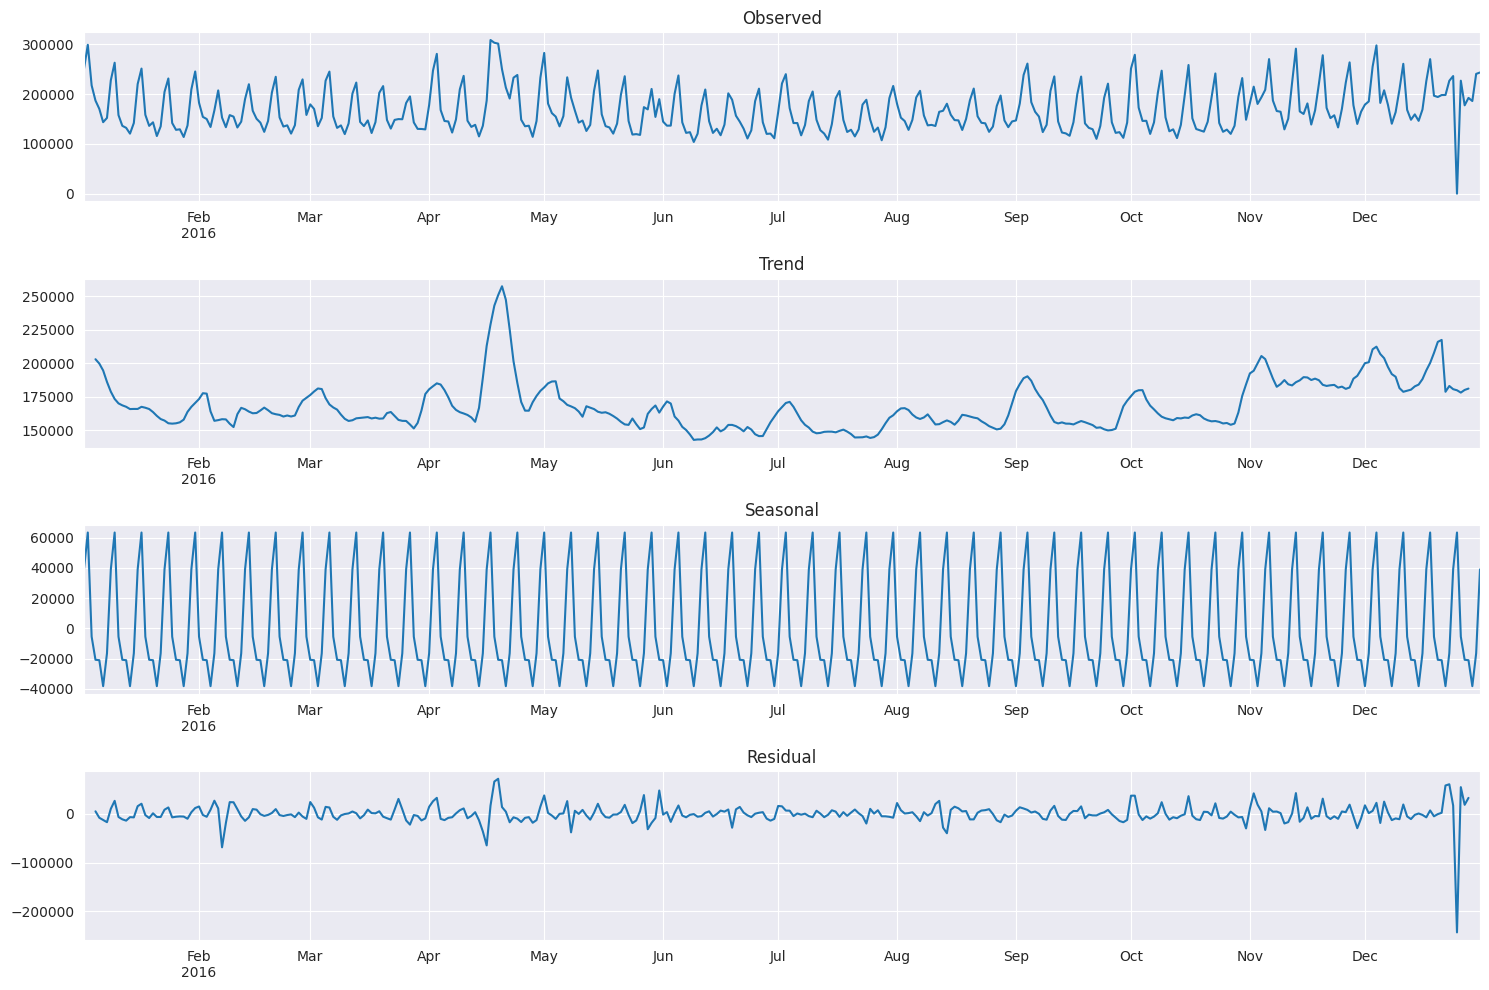

In [151]:
decomp = seasonal_decompose(daily_sales_beverages_2016['sales'], model='additive', period=7)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))

decomp.observed.plot(ax=ax1)
ax1.set_xlabel('')
ax1.set_title('Observed')

decomp.trend.plot(ax=ax2)
ax2.set_xlabel('')
ax2.set_title('Trend')

decomp.seasonal.plot(ax=ax3)
ax3.set_xlabel('')
ax3.set_title('Seasonal')

decomp.resid.plot(ax=ax4)
ax4.set_xlabel('')
ax4.set_title('Residual')

plt.tight_layout()


Text(0.5, -0.3, 'Figura 2.4  A presença de autocorrelação positiva em três defasagens seguida por uma \n autocorrelação negativa em quatro defasagens sugere um padrão cíclico recorrente \n na série temporal, mais especificamente, um período de sete dias, como vimos \n anteriormente. Isso pode indicar que os valores em uma semana \n estão correlacionados positivamente com os valores \n três semanas anteriores, e correlacionados \n negativamente com os valores \n quatro semanas anteriores.')

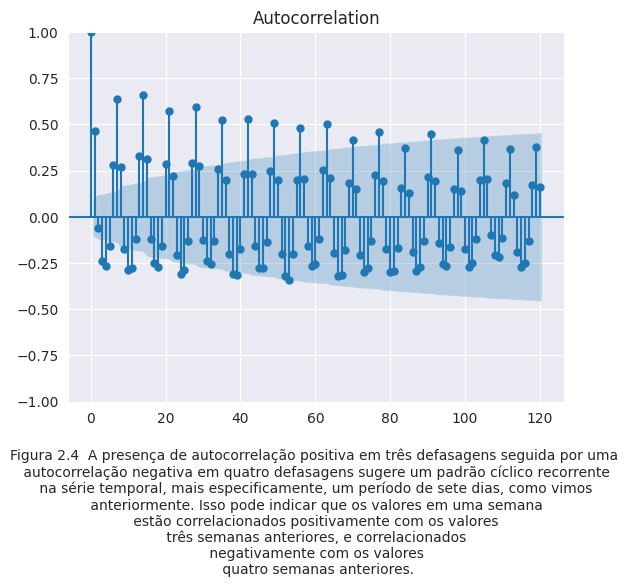

In [185]:
plot_acf(daily_sales_beverages_2016['sales'], lags=120);
plt.annotate('Figura 2.4  A presença de autocorrelação positiva em três defasagens seguida por uma \n autocorrelação negativa em quatro defasagens sugere um padrão cíclico recorrente \n na série temporal, mais especificamente, um período de sete dias, como vimos \n anteriormente. Isso pode indicar que os valores em uma semana \n estão correlacionados positivamente com os valores \n três semanas anteriores, e correlacionados \n negativamente com os valores \n quatro semanas anteriores.', xy=(0.5, -0.3), va='center', xycoords='axes fraction', ha='center')

Text(0.5, -0.25, 'Figura 2.5  As correlações são significativas nos primeiros lags e depois diminuem, \n tornando-se pouco significativas e adentrando à faixa de confiança um pouco \n depois do lag 20, isso pode indicar que há uma estrutura de autocorrelação \n significativa nos primeiros lags da nossa série, porém essa autocorrelação \n diminui à medida que as defasagens aumentam.')

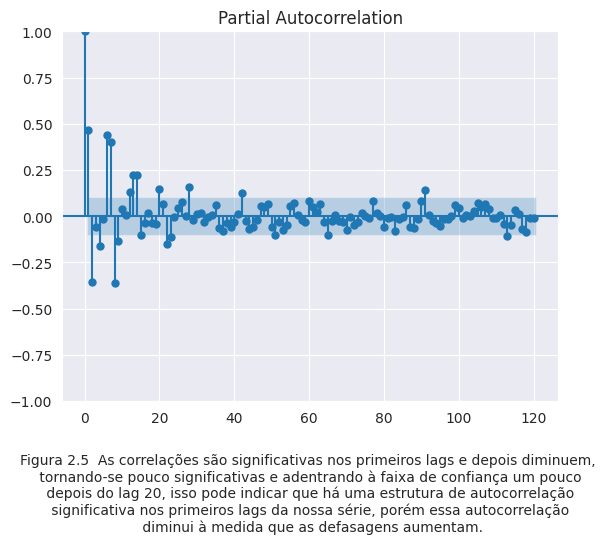

In [199]:
plot_pacf(daily_sales_beverages_2016['sales'], lags=120);
plt.annotate('Figura 2.5  As correlações são significativas nos primeiros lags e depois diminuem, \n tornando-se pouco significativas e adentrando à faixa de confiança um pouco \n depois do lag 20, isso pode indicar que há uma estrutura de autocorrelação \n significativa nos primeiros lags da nossa série, porém essa autocorrelação \n diminui à medida que as defasagens aumentam.', xy=(0.5, -0.25), va='center', xycoords='axes fraction', ha='center')

## 3. Modelagem e previsão

In [24]:
result = adfuller(daily_sales_beverages_2016['sales'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.4073222878076566
p-value: 0.13968040357787342
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


In [25]:
diff_serie = np.diff(daily_sales_beverages_2016['sales'], n=1)

result = adfuller(diff_serie)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.818211366909578
p-value: 8.5372871785001e-22
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


### 3.1 ARIMA

In [26]:
ps = range(0, 8, 1)  # 8 para tentar capturar a informação sazonal
qs = range(0, 8, 1)
Ps = [0]
Qs = [0]

d = 1     
D = 0     
s = 7     

ARIMA_order_list = list(product(ps, qs, Ps, Qs)) # gera todas as possíveis combinações de (p,d,q)(0,0,0).

In [27]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
  results=[]
  for order in tqdm_notebook(order_list):
    try:
        model = SARIMAX(endog,
                        order=(order[0], d, order[1]),
                        seasonal_order=(order[2], D, order[3], s),
                        simple_differencing=False).fit(disp=False)

        aic = model.aic
        results.append([order, aic])
   
    except:
          continue
    
  result_df = pd.DataFrame(results)
  result_df.columns = ['(p,q,P,Q)', 'AIC']

  # orderna em ordem ascendente, quanto menor o AIC, melhor
  result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

  return result_df

In [28]:
train = daily_sales_beverages_2016['sales'][:182]
test =  daily_sales_beverages_2016['sales'][182:]
test = test.drop(test.index[-1])

In [29]:
ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s)
ARIMA_result_df

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(7, 7, 0, 0)",4147.579581
1,"(7, 6, 0, 0)",4164.030130
2,"(6, 6, 0, 0)",4172.720373
3,"(6, 7, 0, 0)",4175.655727
4,"(5, 7, 0, 0)",4188.766470
...,...,...
59,"(3, 0, 0, 0)",4343.739306
60,"(1, 1, 0, 0)",4364.875851
61,"(0, 1, 0, 0)",4370.699068
62,"(1, 0, 0, 0)",4377.775117


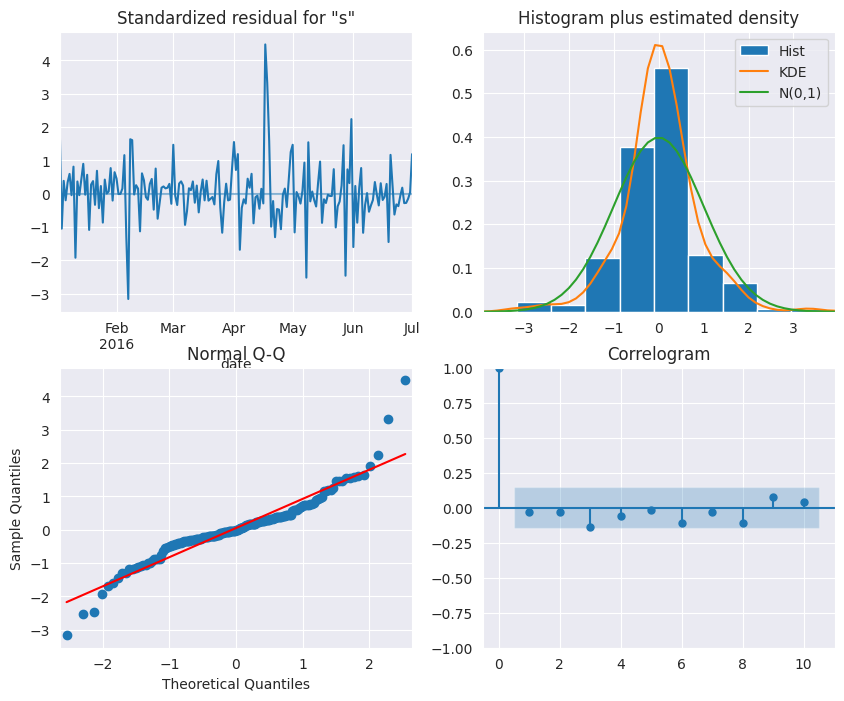

In [201]:
ARIMA_model = SARIMAX(train, order=(7,1,7), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [31]:
residuals = ARIMA_model_fit.resid
acorr_ljungbox(residuals, lags=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], return_df=True)

,lb_stat,lb_pvalue
1,0.937188,0.333002
2,1.830036,0.400509
3,2.458003,0.482929
4,2.874331,0.579071
5,2.891548,0.716701
6,3.129654,0.792407
7,3.151966,0.870597
8,3.348848,0.910599
9,3.811923,0.923349
10,4.089958,0.943198


In [32]:
# Gerar as previsões para o conjunto de teste
predictions = ARIMA_model_fit.get_prediction()
mean_ARIMA = predictions.predicted_mean

### 3.2 SARIMAX

In [203]:
holiday_events_df = holiday_events_df.reset_index()
oil_df = oil_df.reset_index()

In [204]:
daily_promotions_beverages_2016 = daily_sales_beverages_2016

In [205]:
national_holidays_2016 = holiday_events_df[(holiday_events_df['date'] >= '2016-01-02') & (holiday_events_df['date'] <= '2016-12-31') & (holiday_events_df['locale'] == 'National')]

dates = pd.date_range(start='2016-01-02', end='2016-12-31', freq='D')
df_dates_holidays = pd.DataFrame({'date': dates})

# Definir inicialmente todos os valores da coluna 'is_holiday' como False
df_dates_holidays['is_holiday'] = False

# Marcar as datas que tiveram feriado como True
df_dates_holidays.loc[df_dates_holidays['date'].isin(national_holidays_2016['date']), 'is_holiday'] = True
df_dates_holidays.set_index('date', inplace=True)

In [206]:
oil_df_2016 = oil_df[(oil_df['date'] >= '2016-01-02') & (oil_df['date'] <= '2016-12-31')]
df_dates = pd.DataFrame({'date': dates})
df_oil_2016_complete = df_dates.merge(oil_df_2016, on='date', how='left') #  left join para preservar todas as datas de "df_dates":
df_oil_2016_complete['dcoilwtico'].fillna(method='ffill', inplace=True) # preencher com valor anterior
df_oil_2016_complete['dcoilwtico'].fillna(method='bfill', inplace=True) # preencher com o próximo valor 
df_oil_2016_complete.set_index('date', inplace=True)

In [207]:
exogenous_data = pd.DataFrame()
exogenous_data['is_holiday'] = df_dates_holidays['is_holiday']
exogenous_data['onpromotion'] = daily_promotions_beverages_2016['onpromotion']
exogenous_data['dcoilwtico'] = df_oil_2016_complete['dcoilwtico']
exogenous_data['is_holiday'] = exogenous_data['is_holiday'].astype(int)
exogenous_data.index = daily_promotions_beverages_2016.index
exogenous_data

,is_holiday,onpromotion,dcoilwtico
date,,,
2016-01-02,0,155,36.81
2016-01-03,0,154,36.81
2016-01-04,0,151,36.81
2016-01-05,0,164,35.97
2016-01-06,0,156,33.97
...,...,...,...
2016-12-27,0,2815,52.82
2016-12-28,0,3152,54.01
2016-12-29,0,3028,53.80


In [208]:
filtered_exogenous_data = exogenous_data.loc['2016-01-02':'2016-07-01']
filtered_exogenous_data

,is_holiday,onpromotion,dcoilwtico
date,,,
2016-01-02,0,155,36.81
2016-01-03,0,154,36.81
2016-01-04,0,151,36.81
2016-01-05,0,164,35.97
2016-01-06,0,156,33.97
...,...,...,...
2016-06-27,0,449,45.80
2016-06-28,0,437,47.93
2016-06-29,0,427,49.85


In [39]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
  results = []
  for order in tqdm_notebook(order_list):
    try:
        model = SARIMAX(
            endog,
            exog,
            order=(order[0], d, order[1]),
            seasonal_order=(order[2], D, order[3], s),
            simple_differencing=False).fit(disp=False)
        
        aic = model.aic
        results.append([order, aic])
    except:
        continue
  
  result_df = pd.DataFrame(results)
  result_df.columns = ['(p,q,P,Q)', 'AIC']
  
  result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
  
  return result_df

In [40]:
ps = range(0, 4, 1) 
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

d = 1     
D = 0     
s = 7     

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

In [41]:
result_df = optimize_SARIMAX(train, filtered_exogenous_data, SARIMA_order_list, d, D, s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(0, 0, 1, 1)",4146.711367
1,"(0, 0, 2, 1)",4165.572768
2,"(0, 0, 3, 1)",4166.998051
3,"(0, 0, 2, 2)",4167.268557
4,"(0, 0, 1, 3)",4168.091141
...,...,...
250,"(3, 0, 0, 0)",4331.728724
251,"(1, 1, 0, 0)",4351.479137
252,"(0, 1, 0, 0)",4356.558711
253,"(1, 0, 0, 0)",4361.778854


In [209]:
model = SARIMAX(train, filtered_exogenous_data, order=(0,1,0), seasonal_order=(1,0,1,7), simple_differencing=False)
SARIMA_model_fit = model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               sales   No. Observations:                  182
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -2067.356
Date:                             Mon, 29 May 2023   AIC                           4146.711
Time:                                     23:03:24   BIC                           4165.902
Sample:                                 01-02-2016   HQIC                          4154.492
                                      - 07-01-2016                                         
Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
is_holiday   5276.9086     48.450    108.914      0.000    5181.948    5371.869
onpromotion    20.1573  

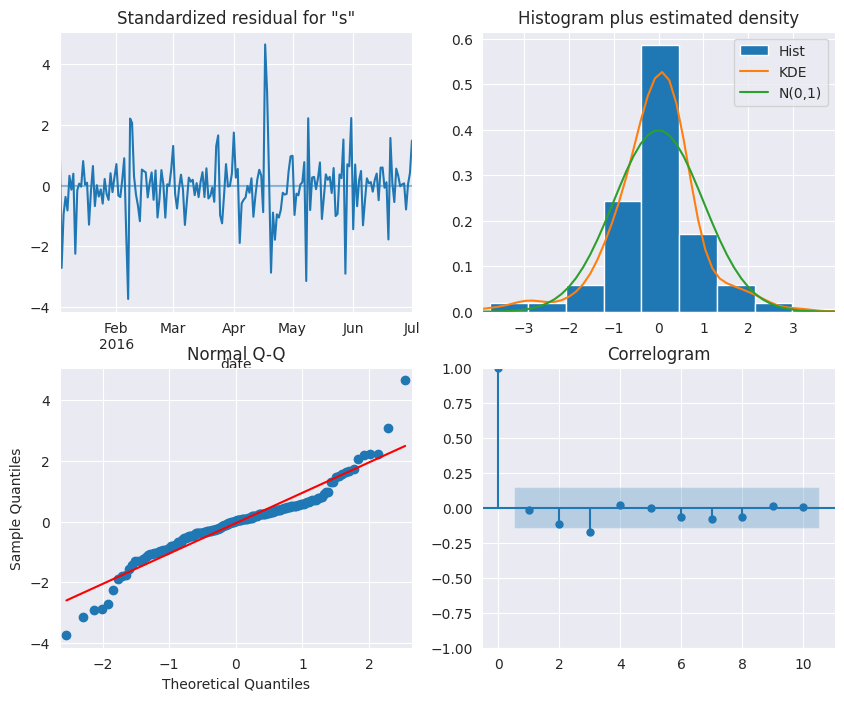

In [210]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [44]:
residuals = SARIMA_model_fit.resid
acorr_ljungbox(residuals, lags=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], return_df=True)

,lb_stat,lb_pvalue
1,0.442690,0.505827
2,7.800772,0.020234
3,12.737448,0.005240
4,12.740508,0.012616
5,12.893964,0.024393
6,13.127837,0.041050
7,13.377235,0.063433
8,13.811431,0.086815
9,14.801034,0.096548
10,14.801048,0.139485


In [211]:
predictions = SARIMA_model_fit.get_prediction(exog=filtered_exogenous_data)
mean_SARIMA = predictions.predicted_mean
confidence_interval = predictions.conf_int()

In [212]:
df_predictions = pd.DataFrame({'ARIMA': mean_ARIMA.values, 'SARIMAX': mean_SARIMA.values, 'test': test.values},  index=test.index)
df_predictions

,ARIMA,SARIMAX,test
date,,,
2016-07-02,0.000000,101652.878767,221451.0
2016-07-03,243928.781165,250489.842739,240162.0
2016-07-04,246879.540953,299116.528218,171926.0
2016-07-05,176271.083222,215538.635184,141837.0
2016-07-06,175708.559051,181554.386665,141899.0
...,...,...,...
2016-12-26,149875.811049,141888.708046,227027.0
2016-12-27,126387.513238,136753.814672,177554.0
2016-12-28,124082.890212,119928.710844,192477.0


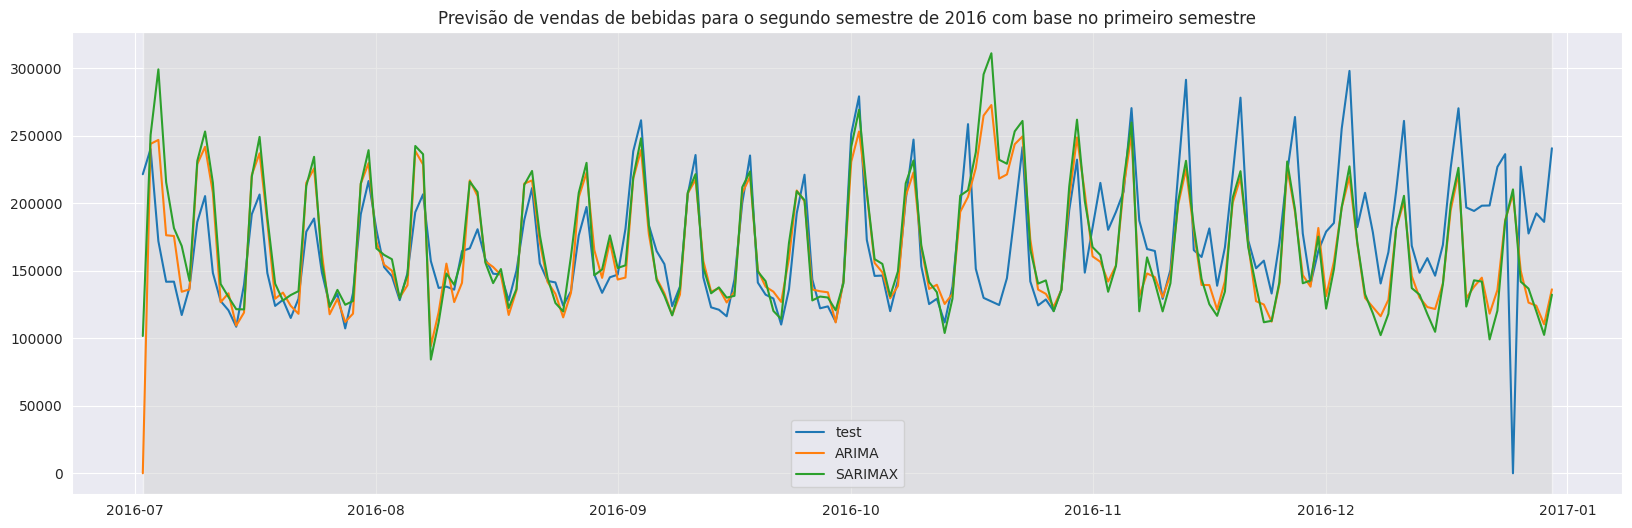

In [213]:
# Obter a posição do índice correspondente à data de início da previsão
posicao_inicio_previsao = df_predictions.index.get_loc('2016-07-02')

# Obter a posição do último índice
posicao_ultimo_indice = len(df_predictions.index) - 1

plt.figure(figsize=(20,6))
sns.set_style("darkgrid")
#sns.lineplot(data=train, label='train')
sns.lineplot(data=df_predictions['test'], label='test')
sns.lineplot(data=df_predictions['ARIMA'], label='ARIMA')
sns.lineplot(data=df_predictions['SARIMAX'], label='SARIMAX')
plt.axvspan(df_predictions.index[posicao_inicio_previsao], df_predictions.index[posicao_ultimo_indice], facecolor='lightgray', alpha=0.5)
plt.ylabel('')
plt.xlabel('')
plt.title('Previsão de vendas de bebidas para o segundo semestre de 2016 com base no primeiro semestre')
plt.show()

In [214]:
df_predictions_reduced = df_predictions.loc[:'2016-10-15']

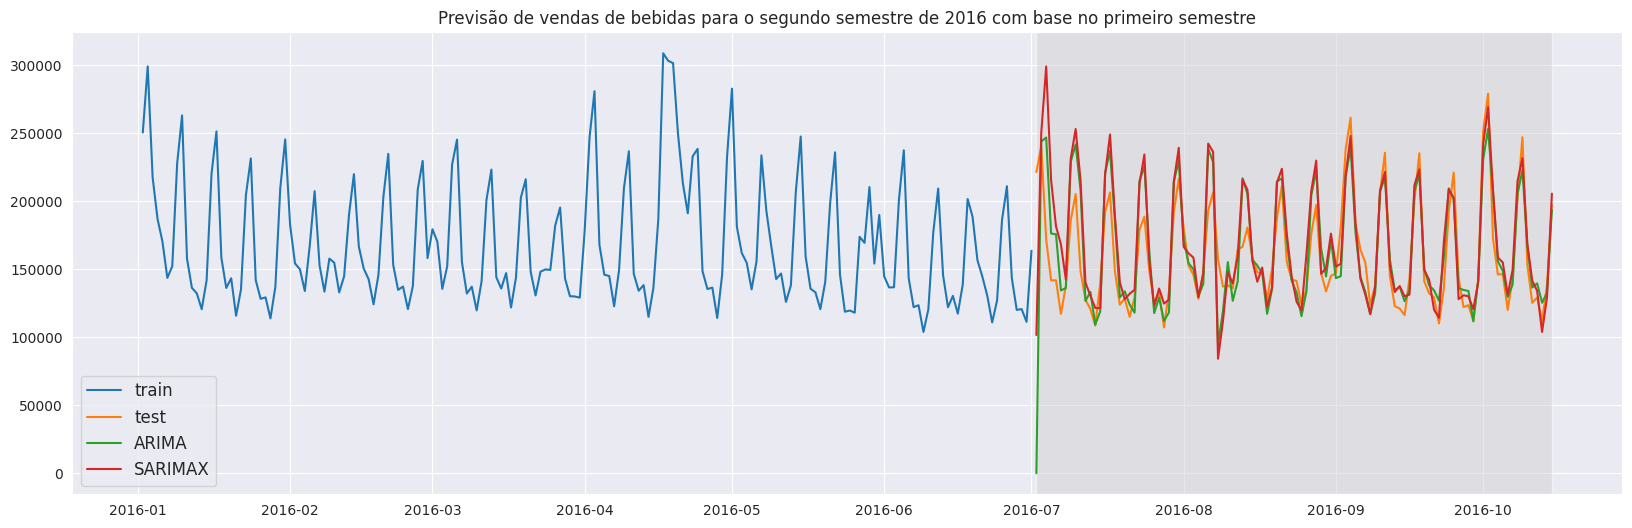

In [215]:
# Obter a posição do índice correspondente à data de início da previsão
posicao_inicio_previsao = df_predictions_reduced.index.get_loc('2016-07-02')

# Obter a posição do último índice
posicao_ultimo_indice = len(df_predictions_reduced.index) - 1

plt.figure(figsize=(20,6))
sns.set_style("darkgrid")
sns.lineplot(data=train, label='train')
sns.lineplot(data=df_predictions_reduced['test'], label='test')
sns.lineplot(data=df_predictions_reduced['ARIMA'], label='ARIMA')
sns.lineplot(data=df_predictions_reduced['SARIMAX'], label='SARIMAX')
plt.axvspan(df_predictions_reduced.index[posicao_inicio_previsao], df_predictions_reduced.index[posicao_ultimo_indice], facecolor='lightgray', alpha=0.5)
plt.ylabel('')
plt.xlabel('')
plt.title('Previsão de vendas de bebidas para o segundo semestre de 2016 com base no primeiro semestre')
plt.legend(fontsize=12)
plt.show()

In [50]:
# uma casa decimal apenas
df_predictions_reduced['ARIMA'] = df_predictions_reduced['ARIMA'].round(1)
df_predictions_reduced['SARIMAX'] = df_predictions_reduced['SARIMAX'].round(1)
df_predictions_reduced['test'] = df_predictions_reduced['test'].round(1)

In [51]:
# atribuir o primeiro valor de SARIMAX a ARIMA
df_predictions_reduced.loc['2016-07-02', 'ARIMA'] = df_predictions_reduced.loc['2016-07-02', 'SARIMAX']

In [52]:
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mape_arima = calculate_mape(df_predictions_reduced['test'], df_predictions_reduced['ARIMA'])
mape_sarimax = calculate_mape(df_predictions_reduced['test'], df_predictions_reduced['SARIMAX'])

print("MAPE ARIMA:", mape_arima)
print("MAPE SARIMAX:", mape_sarimax)

MAPE ARIMA: 10.378163360779025
MAPE SARIMAX: 12.02290419141817


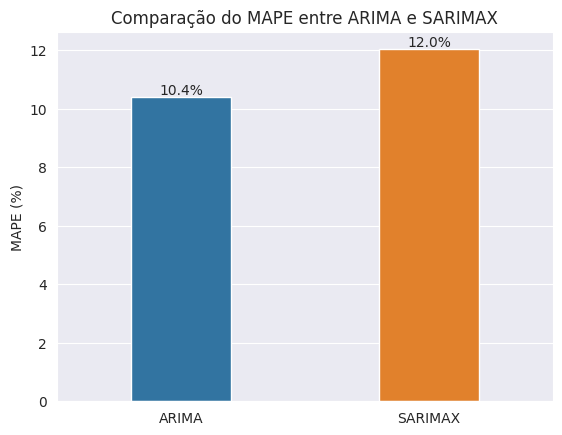

In [53]:
# Criar um dataframe com os mapes
mapes = {'Model': ['ARIMA', 'SARIMAX'],
         'MAPE':  [mape_arima, mape_sarimax]}
mapes_df = pd.DataFrame(mapes)

# Plotar o gráfico de barras usando Seaborn
ax = sns.barplot(x='Model', y='MAPE', data=mapes_df, width=0.4)

# Adicionar os rótulos de porcentagem nas barras
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

# Configurar os rótulos e título do gráfico
plt.xlabel('')
plt.ylabel('MAPE (%)')
plt.title('Comparação do MAPE entre ARIMA e SARIMAX')

# Exibir o gráfico
plt.show()